### 主要目的: 透過資料預測計程車車資

### 載入pandas讀取資料  

In [1]:
import pandas as pd
df = pd.read_csv("train.csv",nrows= 5000000)

由於資料太龐大，所以只讀前500萬筆資料作分析

### 觀察資料

In [2]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


可使用的資料有:
1. 日期時間 (pickup_datetime)
2. 上車的經度、緯度 (pickup_longitude,pickup_latitude)
3. 下車的經度、緯度 (dropoff_longitude,dropoff_latitude)
4. 乘客人數

### 觀察資料型態

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 305.2+ MB


### 可以發現:
時間(pickup_datetime) 型態為 object ，此型態不易於分析需要轉換成好分析的數字。

### 解法:

透過 pd.to_datetime 把時間型態轉換為 datetime64[ns]  

其中的 format = '%Y-%m-%d %H:%M:%S UTC' 是告訴 python 如何拆分時間做轉換

In [4]:
%%time
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC' ) 

CPU times: total: 7.06 s
Wall time: 11.8 s


### 檢查轉換後的型態

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   key                object        
 1   fare_amount        float64       
 2   pickup_datetime    datetime64[ns]
 3   pickup_longitude   float64       
 4   pickup_latitude    float64       
 5   dropoff_longitude  float64       
 6   dropoff_latitude   float64       
 7   passenger_count    int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 305.2+ MB


pickup_datetime 已經成功從 object 轉換成 datetime64[ns]

關於 datetime64[ns]：  
是從 1970,1月1號開始計時，並精細到 nanosecond 的累計時間。 是一個以 64bit 儲存的 integer

### 觀察資料性質

In [6]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076711e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


### 透過觀察最大、最小值可以發現
##### 1. fare_amount 最小值為 -1.000000e+02 為負，不合理。因此要來剔除

##### 2. 透此為紐約市的計程車車資分析，因此須剔除經緯度在紐約市以外的資料  

##### 3. 乘客數 (passenger_count) 最小值為0，最大值為 208 不合理
 

### 檢查是否有缺失值

In [7]:
df.isnull().any()

key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

### 修正:

1. 網路上找到的最低紐約車資: 2.5 $ ，剔除此車資以下的資料
2. 網路上搜尋:  
紐約市經度: longitude = -73.935242  紐約市緯度: latitude = 40.730610  
假定紐約市範圍為 經度: -75,-72 緯度: 40,42 ，只保留此經緯度範圍的資料
3. 剔除乘客數為0的資料 

In [8]:
df = df.loc[df['pickup_latitude'].between(40,42)] 
df = df.loc[df['pickup_longitude'].between(-75,-72)] 
df = df.loc[df['dropoff_latitude'].between(40,42)]
df = df.loc[df['dropoff_longitude'].between(-75,-72)]
df = df.loc[df['fare_amount']>2.5]
df = df.loc[df['passenger_count']>0]

### 再次檢查遺漏值

In [9]:
df.isnull().any()


key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
dtype: bool

In [10]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

可以發現，經過數據處理後，已無遺漏值

### 接下來處理乘客數

### 觀察乘客數分布

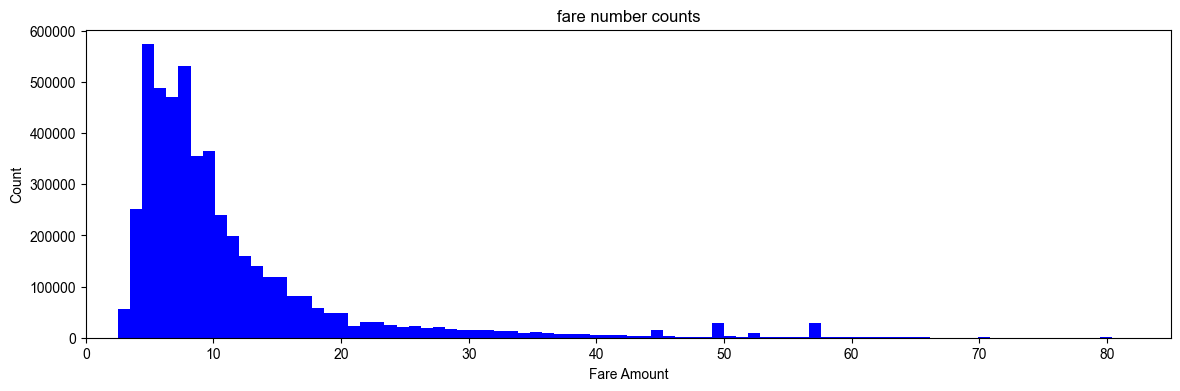

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
plt.hist(df['fare_amount'],1000,facecolor= 'blue')
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.xlim([0,85])
plt.title('fare number counts')
plt.style.use('seaborn-dark')

In [13]:
df['passenger_count'].value_counts()


1      3370483
2       722272
5       345048
3       214472
4       103668
6       103351
9            2
208          2
129          1
7            1
Name: passenger_count, dtype: int64

<AxesSubplot:>

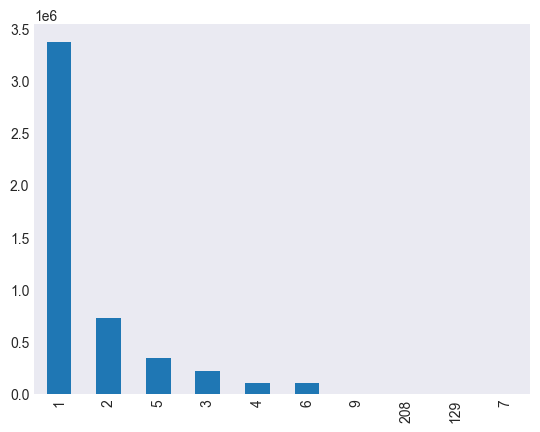

In [14]:
df['passenger_count'].value_counts().plot.bar()

### 為了讓乘客數這個參數有好的權重影響，我決定剔除極端值 只取人數小於等於6的部分。

BTW, 一台計程車怎麼做9個人啊!!!

In [15]:
df =df.loc[df['passenger_count'] <= 6]

### 檢查乘客數

In [16]:
df['passenger_count'].value_counts()

1    3370483
2     722272
5     345048
3     214472
4     103668
6     103351
Name: passenger_count, dtype: int64

### 影響車資的參數可能有
1. 上下車地點 (已有，經緯度表示)
2. 乘車時間 
3. 乘車距離 
4. 交通狀況




1. Distance 
2. Time of ride
3. Traffic
4. No of passengers
5. Pickup and dropoff locations

### 地圖圖示化(炫)

In [17]:
import folium

In [18]:
nyc = folium.Map(location = [ 40.730610,-73.935242],zoom_start =12)


In [19]:
nyc

### 標上 上車位置

In [20]:
for i in df.index[:100]:
    folium.CircleMarker(location= [df['pickup_latitude'][i], df['pickup_longitude'][i] ],color = 'green').add_to(nyc)

In [21]:
nyc

### 標上下車位置

In [22]:
for i in df.index[:100]:
    folium.CircleMarker(location= [df['dropoff_latitude'][i], df['dropoff_longitude'][i] ],color = 'red').add_to(nyc)

In [23]:
nyc

### 修改乘車時間表示方式


把時間年、月、日、星期幾、幾點分項分欄，以做更好的預測。

In [27]:
df['year']= df.pickup_datetime.dt.year
df['month']= df.pickup_datetime.dt.month
df['day']= df.pickup_datetime.dt.day
df['weekday']= df.pickup_datetime.dt.weekday
df['hour']= df.pickup_datetime.dt.hour

### 檢視修改後的時間

In [28]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


### 算乘車距離

### 地球表面上的距離計算:
方法: Fast Harversine approximation  
參考資料:
https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas


In [30]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

### 引用涵式算出乘車距離

In [31]:
df['distance']= haversine_np(df['pickup_longitude'],df['pickup_latitude'],df['dropoff_longitude'],df['dropoff_latitude'])

### 檢查資料

In [32]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,1.030117
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,8.444828
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,1.388653
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,2.797513
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,1.997902


In [33]:
import seaborn as sns 

### 檢查 乘車距離資料分布，是否有問題

C:\Users\Lun\AppData\Local\Temp\ipykernel_23440\2628943672.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['distance'],bins=1000,color='green',kde=False)


<AxesSubplot:xlabel='distance'>

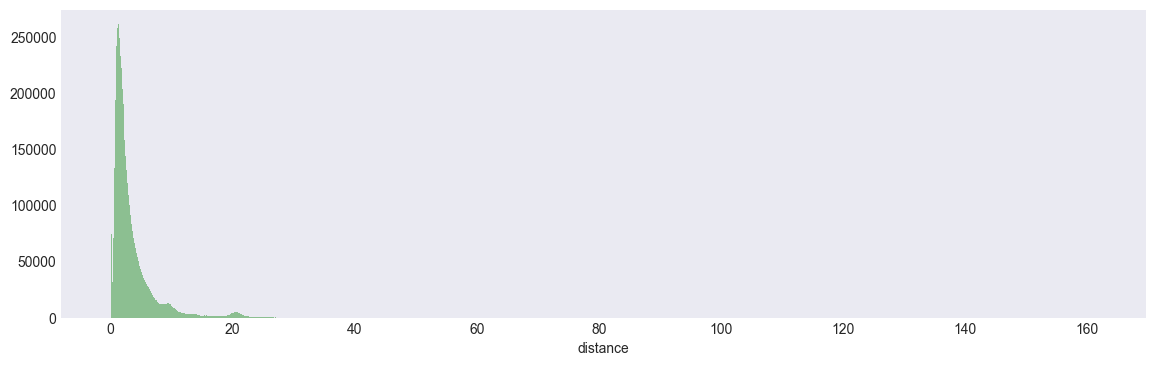

In [39]:
plt.figure(figsize=(14,4))
sns.distplot(df['distance'],bins=1000,color='green',kde=False)

In [40]:
df.distance.describe()

count    4.859294e+06
mean     3.338412e+00
std      3.789936e+00
min      0.000000e+00
25%      1.259794e+00
50%      2.157918e+00
75%      3.916940e+00
max      1.615847e+02
Name: distance, dtype: float64

### 剔除 距離為0的值

In [41]:
df = df.loc[df['distance']>0]

## 建立 model

In [42]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,1.030117
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,8.444828
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,1.388653
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,2.797513
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,1.997902


### 刪除不需要的數據

In [43]:
del df['pickup_datetime']
del df['key']

In [44]:
from sklearn.model_selection import train_test_split

### 把資料分為預測用，測試用

In [45]:
y = df['fare_amount']
X = df.drop(columns = ['fare_amount']) ### 砍掉預測用裡面的 車資答案
X_train, X_test,y_train, y_test = train_test_split( X,y,test_size=0.3,random_state=50) 

### Linear Regression Model


In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

### 檢視預測值契合度

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
from math import sqrt
rms = sqrt(mean_squared_error(y_test,y_pred))

In [50]:
rms

5.230354747980605

In [51]:
from sklearn.metrics import r2_score
r2_score (y_test,y_pred)

0.7055127388585252